<a href="https://colab.research.google.com/github/shivramv757/first-contributions/blob/main/CassavaModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import copy
import json
!pip install optuna
import optuna

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

# augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
#sklearn helpers
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"shivramvenkatachalam","key":"545a50f23799bb861e6594a558fe98ff"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cassava-leaf-disease-classification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
100% 5.75G/5.76G [01:07<00:00, 105MB/s]
100% 5.76G/5.76G [01:07<00:00, 91.8MB/s]


In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [ ]:
BASE_DIR = "/content/"

In [ ]:
train = pd.read_csv(BASE_DIR+'train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
# loading mapping for target label
with open(BASE_DIR+'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
train['label_names'] = train['label'].map(mapping)
train.head()

,image_id,label,label_names
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [ ]:
def plot_images(class_id, label, total_images=6):
    # get image ids corresponding to the target class id
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()

    labels = [label for i in range(total_images)]
    # dynamically set size for subplot
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1

    # set figure size
    plt.figure(figsize=(15,15))

    # plot the image in subplot
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str(BASE_DIR+'train_images/'+image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')

    plt.show()

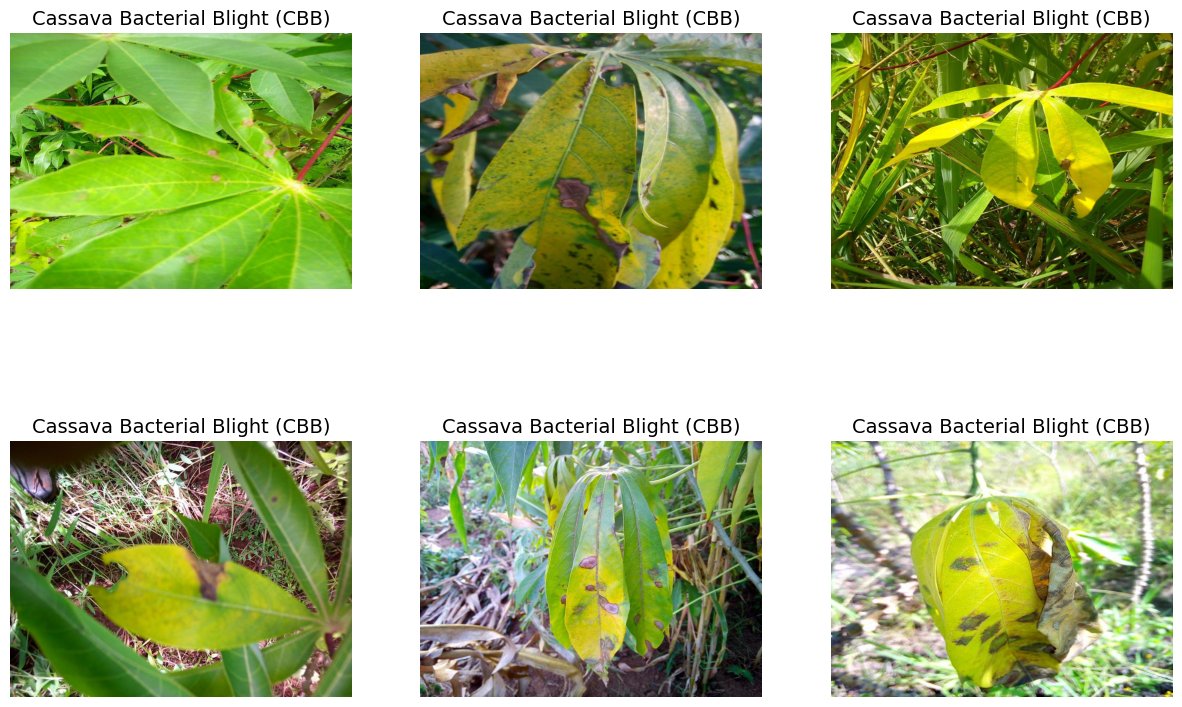

In [ ]:
plot_images(0, mapping[0], 6)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000'),
  Text(12000.0, 0, '12000'),
  Text(14000.0, 0, '14000')])

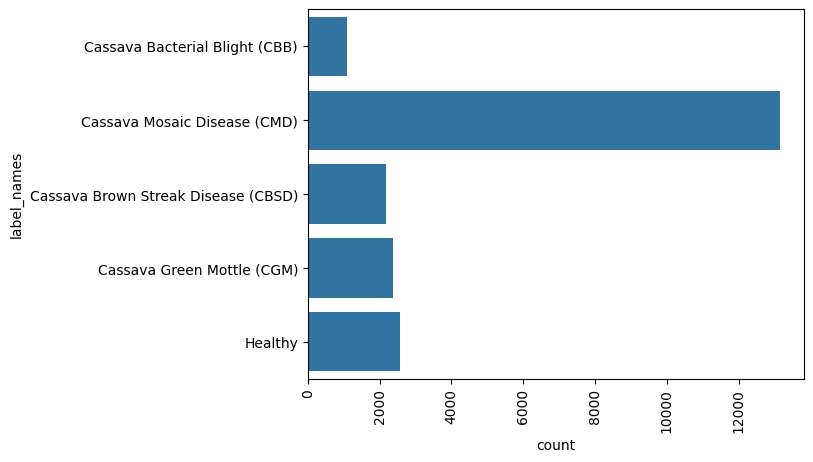

In [ ]:
# class distribution
sns.countplot(train['label_names'])
plt.xticks(rotation=90)

In [ ]:
DIM = (256, 256)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = 24
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
SEED = 1

DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [ ]:
def get_test_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder

    # returns the length
    def __len__(self):
        return len(self.image_ids)

    # return the image and label for that index
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))

        if self.dim:
            img = img.resize(self.dim)

        # convert to numpy array
        img = np.array(img)

        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [ ]:
train_dataset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

val_dataset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}
# to check whether dataset is working or not
# fetch the data based on index
val_dataset[0]


(tensor([[[-0.1999,  0.0912, -0.3198,  ..., -0.1828, -0.4397, -0.5424],
          [-0.1486,  0.0912, -0.2342,  ..., -0.0972,  0.0227, -0.2342],
          [ 0.3138,  0.3138,  0.2111,  ..., -0.2684, -0.3541, -0.2342],
          ...,
          [-1.1418, -1.2274, -1.2788,  ...,  0.2111,  0.4508,  0.6906],
          [-1.2788, -1.3302, -1.4158,  ...,  0.3309,  0.6734,  0.5536],
          [-1.4329, -1.4329, -1.4500,  ...,  0.5364,  0.6049,  0.0912]],
 
         [[ 0.0301,  0.3277, -0.0399,  ..., -0.0399, -0.3025, -0.4076],
          [ 0.0826,  0.3277,  0.0476,  ...,  0.0476,  0.1877, -0.0749],
          [ 0.5378,  0.5378,  0.4853,  ..., -0.1099, -0.1975, -0.0749],
          ...,
          [-1.2129, -1.2654, -1.2829,  ...,  0.2577,  0.4853,  0.6954],
          [-1.3529, -1.3529, -1.4055,  ...,  0.3803,  0.7129,  0.5553],
          [-1.4580, -1.4405, -1.4405,  ...,  0.5903,  0.6429,  0.0651]],
 
         [[ 0.0779,  0.3742, -0.0092,  ..., -0.1138, -0.3753, -0.4624],
          [ 0.1476,  0.3742,

In [ ]:
def getModel(NUM_CLASSES):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  net = models.resnet18(pretrained=True)

    # if you want to train the whole network, comment this code
    # freeze all the layers in the network
  for param in net.parameters():
      param.requires_grad = False

  num_ftrs = net.fc.in_features
    # create last few layers
  net.fc = nn.Sequential(
      nn.Linear(num_ftrs, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, NUM_CLASSES),
      nn.LogSoftmax(dim=1)
  )

    # use gpu if any
  net = net.cuda() if device == 'cuda' else net
  return net
model = getModel(NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


In [ ]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
print(model)
# freeze (or) unfreeze all the layers

unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15, scheduler=scheduler):
    # set starting time
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # append one item to list in each epoch
    val_acc_history    = []
    epoch_results_loss = []
    epoch_results_acc  = []
    epoch_results_f1   = []

    # loop thru each epoch
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*15)

        # stores results for current epoch
        results_acc  = dict()
        results_loss = dict()
        results_f1   = dict()

        # each epoch have training and validation phase
        for phase in ['train', 'val']:
            # set mode for model
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            fin_out = []

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to corresponding hardware
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # reset (or) zero the parameter gradients
                optimizer.zero_grad()

                # training (or) validation process
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # back propagation in the network
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # done with all batches

            # calculate loss and accuarcy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print loss and acc for training & validation
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # update the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            # this is at the end of a phase, put in the results for the current phase
            results_loss[phase] = epoch_loss
            results_acc[phase]  = epoch_acc

        print()

        # done with current epoch, going into the next epoch
        epoch_results_loss.append(results_loss)
        epoch_results_acc.append(results_acc)

    end_time = time.time() - start_time

    print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
# load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, epoch_results_loss, epoch_results_acc


In [ ]:
model, accuracy, epoch_results_loss, epoch_results_acc = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=15, scheduler=scheduler)

Epoch 0/14
---------------
train Loss: 0.2809 Acc: 0.8994
val Loss: 0.5867 Acc: 0.8267

Epoch 1/14
---------------
train Loss: 0.3171 Acc: 0.8874
val Loss: 0.5929 Acc: 0.8221

Epoch 2/14
---------------
train Loss: 0.3442 Acc: 0.8741
val Loss: 0.6172 Acc: 0.8288

Epoch 3/14
---------------
train Loss: 0.3381 Acc: 0.8779
val Loss: 0.6257 Acc: 0.8082

Epoch 4/14
---------------
train Loss: 0.2781 Acc: 0.9004
val Loss: 0.7151 Acc: 0.8002

Epoch 5/14
---------------
train Loss: 0.2479 Acc: 0.9109
val Loss: 0.6704 Acc: 0.8148

Epoch 6/14
---------------
train Loss: 0.2033 Acc: 0.9280
val Loss: 0.6383 Acc: 0.8275

Epoch 7/14
---------------
train Loss: 0.1768 Acc: 0.9390
val Loss: 0.6644 Acc: 0.8292

Epoch 8/14
---------------
train Loss: 0.2047 Acc: 0.9291
val Loss: 0.6469 Acc: 0.8262

Epoch 9/14
---------------
train Loss: 0.2388 Acc: 0.9159
val Loss: 0.7318 Acc: 0.7950

Epoch 10/14
---------------
train Loss: 0.2750 Acc: 0.9014
val Loss: 0.7459 Acc: 0.8026

Epoch 11/14
---------------
tra

In [ ]:
# epoch_results_loss = [{'train': 1.334633530029413, 'val': 1.0736990348980806}, {'train': 1.334633530029413, 'val': 1.0736990348980806}]
# epoch_results_loss
epoch_results_acc

[{'train': tensor(0.8994, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8267, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.8874, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8221, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.8741, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8288, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.8779, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8082, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.9004, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8002, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.9109, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8148, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.9280, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8275, device='cuda:0', dtype=torch.float64)},
 {'train': tensor(0.9390, device='cuda:0', dtype=torch.float64),
  'val': tensor(0.8292, device='

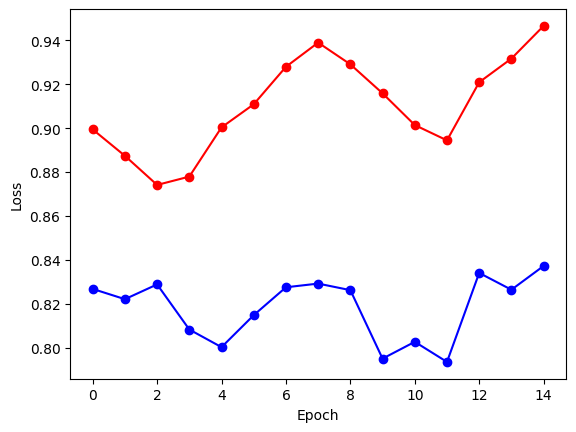

In [ ]:
n_epoch = range(len(epoch_results_acc))
train_avg_loss = [x['train'].cpu() for x in epoch_results_acc]
val_avg_loss = [x['val'].cpu() for x in epoch_results_acc]
plt.plot(n_epoch, train_avg_loss, 'ro-')
plt.plot(n_epoch, val_avg_loss, 'bo-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(target.tolist())

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print("F1 Score:", f1)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# # Test Set
torch.cuda.empty_cache()
def predict(model, dataloader, device):
    # set mode to eval
    model.eval()
    fin_out = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)

            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())

    return np.concatenate(fin_out)
# steps for model prediction
device = torch.device('cuda')
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)
y_test.values[:5]

array([3, 2, 4, 1, 3])

In [ ]:
pred[:5]

array([3, 2, 4, 1, 3])

              precision    recall  f1-score   support

           0       0.58      0.57      0.58       279
           1       0.73      0.76      0.74       555
           2       0.66      0.77      0.71       582
           3       0.96      0.91      0.94      3320
           4       0.64      0.67      0.65       614

    accuracy                           0.84      5350
   macro avg       0.71      0.74      0.72      5350
weighted avg       0.85      0.84      0.84      5350



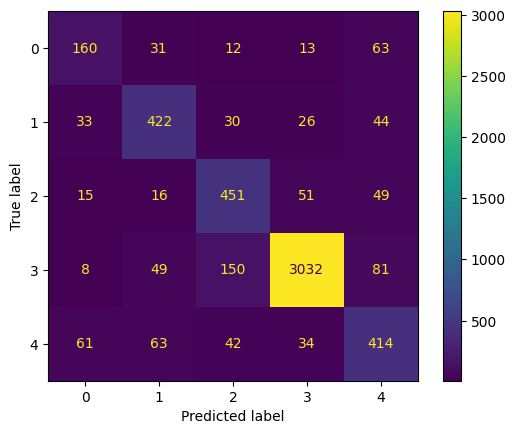

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred, labels = [0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4])
disp.plot()
plt.show()
